In [1]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
import linear_operator_learning.nn as lol
treescope.basic_interactive_setup()

In [2]:
run_id = "zop41q22"
data_path = Path(f"/home/pnovelli/code/encoderops/encoderops_chignolin/{run_id}")
epoch = 499
model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
#embeddings = torch.load(data_path / f"embeddings/epoch={epoch}.pt")

/home/pnovelli/code/encoderops/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import os
import pickle
data_path = Path(os.environ["CHIG_DATA_PATH"])
trajectory_files = [str(traj) for traj in data_path.glob("*.dcd")]
top = next(data_path.glob("*.pdb")).__str__()
name = next(data_path.glob("*.pdb")).stem
lagtime = model.data_args.lagtime
prepro_data_path = (
    Path().cwd() / f"preprocessed_data/{name}-lag{lagtime}.pkl"
)

# If the file exists then load it with pickle, otherwise call get_dataset and save it
if prepro_data_path.exists():
    with open(prepro_data_path, "rb") as f:
        dataset = pickle.load(f)

In [28]:
from tqdm import tqdm
from torch_geometric.loader import DataLoader

embeddings = {"t": [], "lag": []}
model = model.eval()

dataloader = DataLoader(
    dataset, batch_size=128, shuffle=False
)
with torch.no_grad():
    for batch in tqdm(dataloader):
        for k, v in batch.items():
            batch[k] = v.to(model.device)
        # data
        x_t = model._setup_graph_data(batch, key="data_list")
        x_lag = model._setup_graph_data(batch, key="data_list_lag")
        # forward
        f_t = model.forward_nn(x_t)
        f_lag = model.forward_nn(x_lag)
        embeddings["t"].append((f_t.detach().cpu()))
        embeddings["lag"].append((f_lag.detach().cpu()))

100%|██████████| 84/84 [02:08<00:00,  1.53s/it]


In [29]:
phi_t = torch.cat(embeddings["t"])
phi_lag = torch.cat(embeddings["lag"])

In [32]:
cov_X = lol.stats.covariance(phi_t)
cov_Y = lol.stats.covariance(phi_lag)
cov_XY = lol.stats.covariance(phi_lag)
markov_model = lol.ridge_least_squares(cov_X, tikhonov_reg=1e-2)

In [34]:
markov_model

{'U': tensor([[-4.9940e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2141e-01,
           2.0102e-01,  2.3411e-02],
         [-4.9938e+00,  3.5178e-05,  8.9961e-06,  ...,  1.3232e-01,
          -1.8964e-02,  1.4945e-01],
         [-4.9934e+00, -2.1013e-06, -1.5266e-05,  ...,  3.3077e-01,
          -1.6019e-01, -1.1306e-01],
         ...,
         [-6.4066e-02, -6.0755e-01,  7.5656e-01,  ..., -4.0902e-01,
          -1.7422e-01, -7.1015e-04],
         [-6.4044e-02, -6.0753e-01,  7.5653e-01,  ...,  2.4189e-01,
          -1.1094e-01,  1.7444e-01],
         [-6.4130e-02, -6.0752e-01,  7.5653e-01,  ...,  1.0507e-01,
           2.3613e-01,  6.8086e-02]]),
 'V': tensor([[-4.9940e+00,  0.0000e+00,  0.0000e+00,  ..., -1.2141e-01,
           2.0102e-01,  2.3411e-02],
         [-4.9938e+00,  3.5178e-05,  8.9961e-06,  ...,  1.3232e-01,
          -1.8964e-02,  1.4945e-01],
         [-4.9934e+00, -2.1013e-06, -1.5266e-05,  ...,  3.3077e-01,
          -1.6019e-01, -1.1306e-01],
         ...,
         [-6.4066e-02, -6.0755e-01,  7.5656e-01,  ..., -4.0902e-01,
          -1.7422e-01, -7.1015e-04],
         [-6.4044e-02, -6.0753e-01,  7.5653e-01,  ...,  2.4189e-01,
          -1.1094e-01,  1.7444e-01],
         [-6.4130e-02, -6.0752e-01,  7.5653e-01,  ...,  1.0507e-01,
           2.3613e-01,  6.8086e-02]]),
 'svals': tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0102, 0.0102,
         0.0103, 0.0103, 0.0103, 0.0104, 0.0104, 0.0104, 0.0105, 0.0105, 0.0106,
         0.0106, 0.0108, 0.0108, 0.0109, 0.0111, 0.0111, 0.0112, 0.0113, 0.0114,
         0.0115, 0.0116, 0.0118, 0.0120, 0.0123, 0.0125, 0.0127, 0.0129, 0.0136,
         0.0141, 0.0156, 0.0177, 0.0219, 0.0224, 0.0228, 0.0277, 0.0306, 0.0315,
         0.0322, 0.0352, 0.0411, 0.0435, 0.0490, 0.1021, 0.1642, 0.2177, 0.2510,
         0.6861])}

In [35]:
G_0 = markov_model["U"]@markov_model["U"].T@cov_XY
G_1 = model.linear[0].weight.T.detach().cpu()@model.linear[1].weight.T.detach().cpu() @ cov_Y

In [36]:
G_0

tensor([[ 0.2527, -0.0886, -0.0660,  ...,  0.0472, -0.0077, -0.0385],
        [-0.0882,  0.2768, -0.0745,  ..., -0.0293,  0.0083,  0.0091],
        [-0.0659, -0.0742,  0.2401,  ...,  0.0044,  0.0112, -0.0060],
        ...,
        [ 0.0469, -0.0286,  0.0044,  ...,  0.2158, -0.0837, -0.0690],
        [-0.0073,  0.0064,  0.0111,  ..., -0.0834,  0.1640, -0.0739],
        [-0.0382,  0.0095, -0.0061,  ..., -0.0695, -0.0726,  0.2030]])

In [38]:
G_1

tensor([[ 0.3774, -0.1876, -0.0310,  ...,  0.0608,  0.0515, -0.0256],
        [-0.1055,  0.2132,  0.0325,  ..., -0.0097, -0.0640, -0.0711],
        [-0.1611, -0.1065,  0.0139,  ..., -0.0345, -0.0626,  0.0903],
        ...,
        [ 0.4334, -0.1765, -0.0694,  ...,  0.6157, -0.0905, -0.3881],
        [-0.3566, -0.0430,  0.3623,  ..., -0.5088,  0.2432, -0.1237],
        [-0.2818,  0.2445, -0.2134,  ..., -0.4223, -0.1202,  0.6939]])

In [37]:
G_0

tensor([[ 0.2527, -0.0886, -0.0660,  ...,  0.0472, -0.0077, -0.0385],
        [-0.0882,  0.2768, -0.0745,  ..., -0.0293,  0.0083,  0.0091],
        [-0.0659, -0.0742,  0.2401,  ...,  0.0044,  0.0112, -0.0060],
        ...,
        [ 0.0469, -0.0286,  0.0044,  ...,  0.2158, -0.0837, -0.0690],
        [-0.0073,  0.0064,  0.0111,  ..., -0.0834,  0.1640, -0.0739],
        [-0.0382,  0.0095, -0.0061,  ..., -0.0695, -0.0726,  0.2030]])

In [39]:
e0 = torch.linalg.eigvals(G_0)
e1 = torch.linalg.eigvals(G_1)

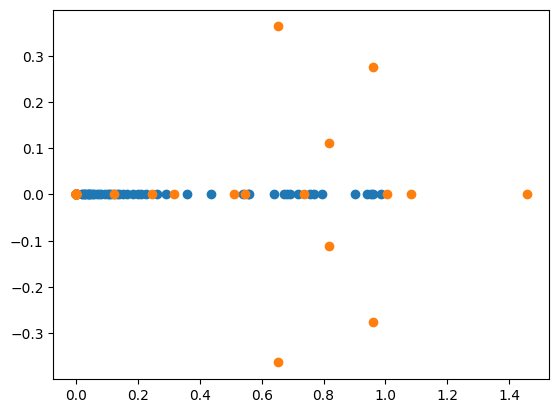

In [41]:
import matplotlib.pyplot as plt
N = phi_t.shape[0]
plt.scatter(e0.real, e0.imag)
plt.scatter(e1.real, e1.imag)

In [43]:
eig_result = lol.eig(markov_model, cov_XY)

In [45]:
e_fun = lol.evaluate_eigenfunction(eig_result, "right", phi_t)

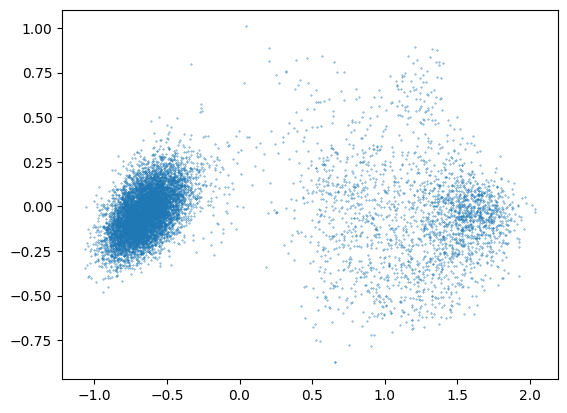

In [63]:
plt.scatter(e_fun[:, -1].real, e_fun[:, -8].real, s=0.1)

In [69]:
print(eig_result['values'])

tensor([-3.4473e-07-1.0572e-07j, -3.4473e-07+1.0572e-07j,
        -3.2282e-07-5.8983e-08j, -3.2282e-07+5.8983e-08j,
        -1.2244e-07-9.4974e-08j, -1.2244e-07+9.4974e-08j,
        -8.1178e-08+0.0000e+00j, -2.4245e-08-1.0266e-07j,
        -2.4245e-08+1.0266e-07j,  8.7444e-08+0.0000e+00j,
         1.0130e-07-4.2656e-08j,  1.0130e-07+4.2656e-08j,
         2.5201e-07+0.0000e+00j,  3.2566e-07-1.0636e-07j,
         3.2566e-07+1.0636e-07j,  4.1321e-07+0.0000e+00j,
         1.8702e-02+0.0000e+00j,  2.0686e-02+0.0000e+00j,
         2.5748e-02+0.0000e+00j,  2.8349e-02+0.0000e+00j,
         3.0139e-02+0.0000e+00j,  3.8927e-02+0.0000e+00j,
         4.0095e-02+0.0000e+00j,  4.0969e-02+0.0000e+00j,
         4.5710e-02+0.0000e+00j,  5.0363e-02+0.0000e+00j,
         5.5617e-02+0.0000e+00j,  5.7863e-02+0.0000e+00j,
         6.9310e-02+0.0000e+00j,  7.6238e-02+0.0000e+00j,
         8.1411e-02+0.0000e+00j,  9.5262e-02+0.0000e+00j,
         1.0217e-01+0.0000e+00j,  1.0789e-01+0.0000e+00j,
         1.141